In [23]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from typing import Optional, Sequence

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

class BinaryBTSPNetworkTorch:
    """二值 BTSP 网络（CA3 -> CA1），使用 PyTorch 加速"""
    def __init__(
        self,
        n_input: int,
        n_memory: int,
        weight_density: float,
        threshold: Optional[Sequence[int]] = None,
        device: Optional[str] = None,
    ):
        self.device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))
        print(f"使用设备: {self.device}")
        self.n_input = n_input
        self.n_memory = n_memory

        # 随机初始化二值权重
        self.weights = (torch.rand(n_memory, n_input, device=self.device) < weight_density).to(torch.uint8)

        # 阈值
        if threshold is None:
            incoming = self.weights.sum(dim=1)
            thr = (incoming.float() / 2).ceil().to(torch.int)
            thr[thr < 1] = 1
            self.threshold = thr
        else:
            thr = torch.tensor(threshold, device=self.device, dtype=torch.int)
            if thr.shape == ():
                thr = thr.repeat(n_memory)
            self.threshold = thr

    def forward(self, input_pattern: Sequence[int]) -> torch.Tensor:
        """前向传播"""
        x = torch.as_tensor(input_pattern, dtype=torch.uint8, device=self.device)
        if x.shape != (self.n_input,):
            raise ValueError(f"input_pattern must have shape ({self.n_input},), got {x.shape}")
        summed = torch.matmul(self.weights.float(), x.float())  # shape: (n_memory,)
        out = (summed >= self.threshold).to(torch.uint8)
        return out

    def btsp_update(self, input_pattern: Sequence[int], update_prob: float = 0.005) -> None:
        """BTSP 更新（概率翻转 0/1 突触）
        参数:
            input_pattern: 输入模式 (0/1 向量)
            update_prob:   突触翻转概率 (默认 0.5)
        """
        x = torch.as_tensor(input_pattern, dtype=torch.uint8, device=self.device)
        active_idx = torch.nonzero(x, as_tuple=True)[0]
        if active_idx.numel() == 0:
            return

        # 以 update_prob 概率生成翻转掩码
        flips = (torch.rand(self.n_memory, active_idx.numel(), device=self.device) < update_prob).to(torch.uint8)

        # XOR 翻转
        sub = self.weights[:, active_idx]
        self.weights[:, active_idx] = sub ^ flips


    def train(self, patterns: Sequence[Sequence[int]]) -> None:
        """训练多个模式"""
        for i, pat in enumerate(patterns):
            if i % 10 == 0:  # 每10个模式打印一次进度
                print(f"训练进度: {i}/{len(patterns)}")
            self.btsp_update(pat)

    @staticmethod
    def make_sparse_patterns(n_patterns: int, n_input: int, sparsity: float, device: Optional[str] = None) -> torch.Tensor:
        """生成稀疏二值输入模式矩阵"""
        if not (0.0 < sparsity <= 1.0):
            raise ValueError("sparsity must be in (0, 1]")
        device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        return (torch.rand(n_patterns, n_input, device=device) < sparsity).to(torch.uint8)

    def compute_relative_dissimilarity(
        self,
        patterns: torch.Tensor,
        mask_ratios: Sequence[float],
        n_repeats: int = 10,
        eps: float = 1e-8,
    ) -> np.ndarray:
        """
        计算不同掩码比例下的平均相对不相似度
        patterns: (n_patterns, n_input) 二值张量
        mask_ratios: 掩码比例数组，如 [0, 0.1, 0.2, ...]
        n_repeats: 重复次数
        返回: (len(mask_ratios),) 的 numpy 数组
        """
        patterns = patterns.to(self.device)
        n_patterns = patterns.shape[0]

        mean_rel_diss = []
        for mask_ratio in mask_ratios:
            rel_diss_list = []
            for _ in range(n_repeats):
                for idx in range(n_patterns):
                    pattern = patterns[idx]
                    z_orig = self.forward(pattern)

                    # 构造掩码
                    n_mask = int(mask_ratio * pattern.numel())
                    mask = torch.ones_like(pattern)
                    if n_mask > 0:
                        mask_idx = torch.randperm(pattern.numel(), device=self.device)[:n_mask]
                        mask[mask_idx] = 0
                    pattern_masked = pattern * mask
                    z_masked = self.forward(pattern_masked)

                    # 随机挑选另一个 pattern
                    if n_patterns > 1:
                        rand_idx = torch.randint(0, n_patterns - 1, (1,), device=self.device).item()
                        if rand_idx >= idx:
                            rand_idx += 1  # 避免等于自己
                        pattern_rand = patterns[rand_idx]
                    else:
                        pattern_rand = torch.zeros_like(pattern)

                    z_rand = self.forward(pattern_rand)

                    # 归一化海明距离
                    hd_same = (z_orig != z_masked).float().mean().item()
                    hd_rand = (z_orig != z_rand).float().mean().item()
                    rel = hd_same / (hd_rand + eps)
                    rel_diss_list.append(rel)

            mean_rel_diss.append(np.mean(rel_diss_list))

        return np.array(mean_rel_diss)

    @staticmethod
    def visualize_pattern(pattern: torch.Tensor, title: str, ax: plt.Axes) -> None:
        """可视化二值模式"""
        if pattern.device != torch.device('cpu'):
            pattern = pattern.cpu()
        pattern_np = pattern.numpy() if len(pattern.shape) == 1 else pattern.squeeze().numpy()
        
        ax.imshow(pattern_np.reshape(1, -1), cmap='binary', aspect='auto')
        ax.set_title(title)
        ax.set_xlabel('神经元索引')
        ax.set_yticks([])
        ax.set_xticks([0, len(pattern_np)-1])


初始化网络...
使用设备: cuda
生成训练模式...
测试模式活跃神经元: 1/1000

=== 训练前 ===
激活的记忆细胞: 0/2000

=== 开始训练 ===
训练进度: 0/20
训练进度: 10/20
训练完成!

=== 训练后 ===
激活的记忆细胞: 0/2000
记忆细胞重叠: 0/2000
记忆细胞变化: 0/2000


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7416\2655213258.py:116: UserWarning: Glyph 32479 (\N{CJK UNIFIED IDEOGRAPH-7EDF}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7416\2655213258.py:116: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7416\2655213258.py:116: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7416\2655213258.py:116: UserWarning: Glyph 24687 (\N{CJK UNIFIED IDEOGRAPH-606F}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7416\2655213258.py:116: UserWarning: Glyph 35774 (\N{CJK UNIFIED IDEOGRAPH-8BBE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Administrator\AppData

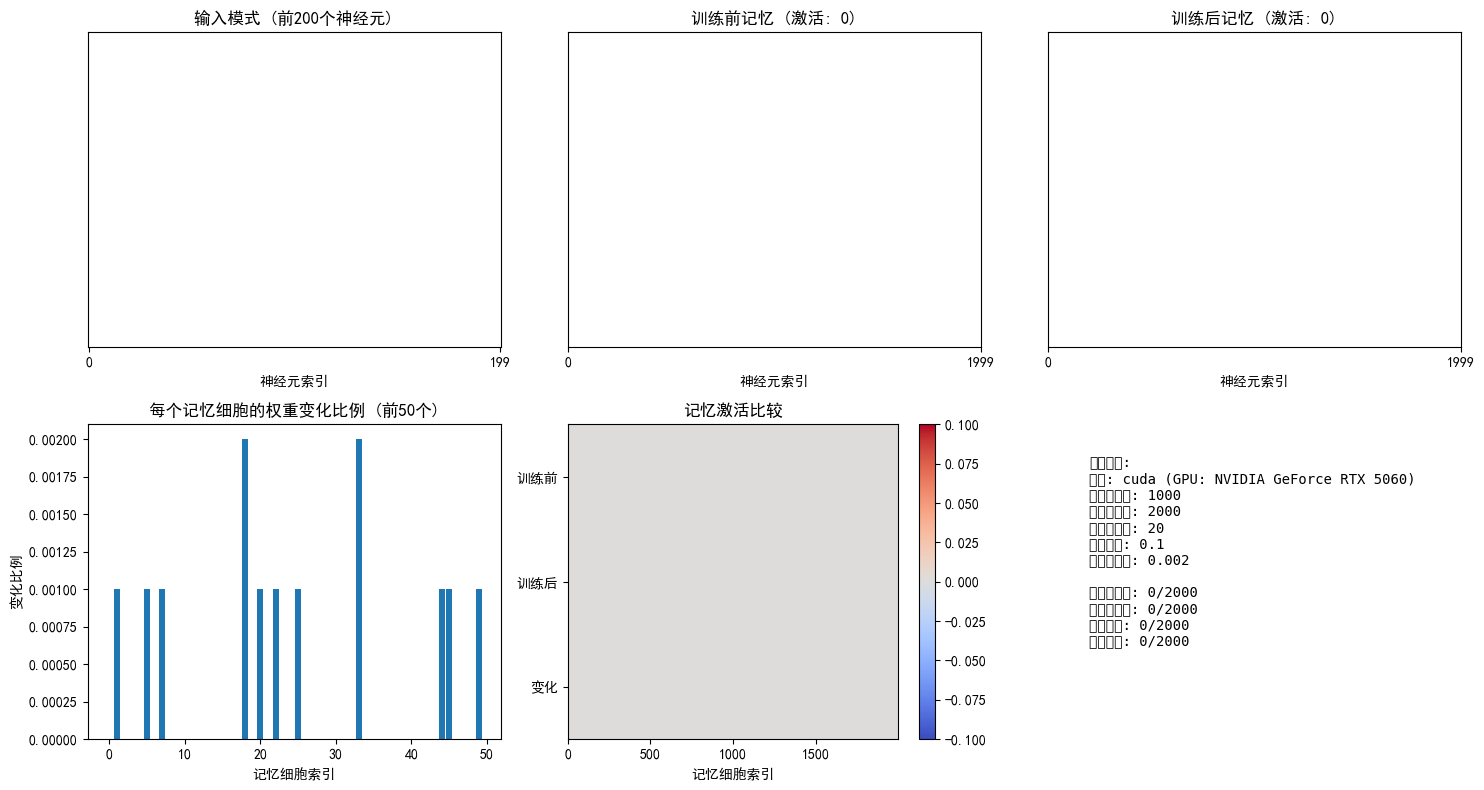


=== 模式完成测试 ===
掩码比例 0.0: 相似度 = 0.000 (0/0 细胞重叠)
掩码比例 0.2: 相似度 = 0.000 (0/0 细胞重叠)
掩码比例 0.5: 相似度 = 0.000 (0/0 细胞重叠)
掩码比例 0.8: 相似度 = 0.000 (0/0 细胞重叠)


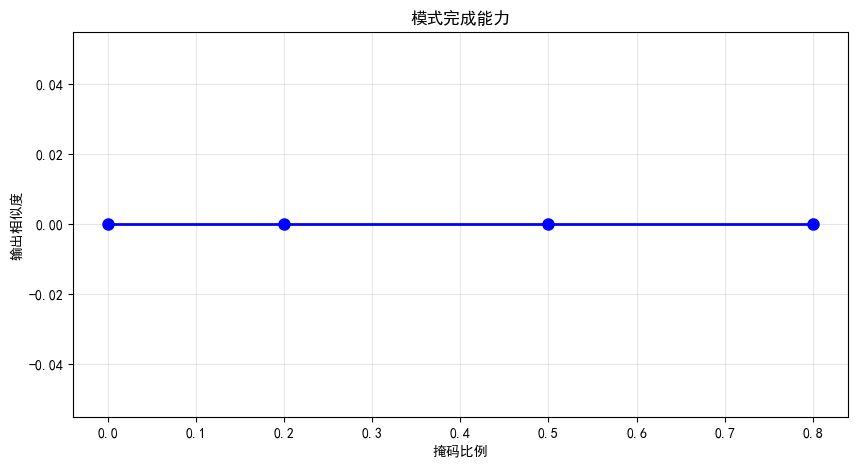

In [24]:

def main():
    # 设置随机种子以便重现结果
    torch.manual_seed(42)
    np.random.seed(42)
    
    # 网络参数
    n_input = 1000      # 输入神经元数量
    n_memory = 2000      # 记忆神经元数量
    weight_density = 0.1  # 连接密度
    n_patterns = 20     # 训练模式数量
    sparsity = 0.002     # 输入模式稀疏度
    
    # 创建网络
    print("初始化网络...")
    network = BinaryBTSPNetworkTorch(
        n_input=n_input,
        n_memory=n_memory,
        weight_density=weight_density,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    
    # 生成训练模式
    print("生成训练模式...")
    patterns = network.make_sparse_patterns(n_patterns, n_input, sparsity, device=network.device)
    
    # 选择一个特定模式用于测试（第一个模式）
    test_pattern = patterns[0]
    print(f"测试模式活跃神经元: {test_pattern.sum().item()}/{n_input}")
    
    # 训练前的前向传播
    print("\n=== 训练前 ===")
    memory_before = network.forward(test_pattern)
    active_memory_before = memory_before.sum().item()
    print(f"激活的记忆细胞: {active_memory_before}/{n_memory}")
    
    # 显示权重矩阵的初始状态
    weights_before = network.weights.clone().cpu()
    
    # 训练网络
    print("\n=== 开始训练 ===")
    network.train(patterns)
    print("训练完成!")
    
    # 训练后的前向传播
    print("\n=== 训练后 ===")
    memory_after = network.forward(test_pattern)
    active_memory_after = memory_after.sum().item()
    print(f"激活的记忆细胞: {active_memory_after}/{n_memory}")
    
    # 计算记忆模式的变化
    memory_before_cpu = memory_before.cpu()
    memory_after_cpu = memory_after.cpu()
    
    memory_overlap = (memory_before_cpu & memory_after_cpu).sum().item()
    memory_changed = (memory_before_cpu != memory_after_cpu).sum().item()
    print(f"记忆细胞重叠: {memory_overlap}/{n_memory}")
    print(f"记忆细胞变化: {memory_changed}/{n_memory}")
    
    # 可视化结果
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # 输入模式（显示前200个神经元以便观察）
    pattern_to_show = test_pattern[:200].cpu() if n_input > 200 else test_pattern.cpu()
    network.visualize_pattern(pattern_to_show, f'输入模式 (前{len(pattern_to_show)}个神经元)', axes[0,0])
    
    # 训练前的记忆激活
    network.visualize_pattern(memory_before_cpu, f'训练前记忆 (激活: {active_memory_before})', axes[0,1])
    
    # 训练后的记忆激活
    network.visualize_pattern(memory_after_cpu, f'训练后记忆 (激活: {active_memory_after})', axes[0,2])
    
    # 权重变化热图（随机选择部分权重显示）
    weights_after_cpu = network.weights.cpu()
    weight_changes = (weights_before != weights_after_cpu).float()
    
    # 显示权重变化密度（每行）
    change_density = weight_changes.mean(dim=1).numpy()
    axes[1,0].bar(range(min(50, n_memory)), change_density[:50])  # 只显示前50个记忆细胞
    axes[1,0].set_title('每个记忆细胞的权重变化比例 (前50个)')
    axes[1,0].set_xlabel('记忆细胞索引')
    axes[1,0].set_ylabel('变化比例')
    
    # 记忆激活的详细比较
    memory_comparison = torch.stack([memory_before_cpu, memory_after_cpu, 
                                   (memory_before_cpu != memory_after_cpu).to(torch.uint8)])
    memory_comparison_np = memory_comparison.numpy()
    
    im = axes[1,1].imshow(memory_comparison_np, cmap='coolwarm', aspect='auto')
    axes[1,1].set_title('记忆激活比较')
    axes[1,1].set_yticks([0, 1, 2])
    axes[1,1].set_yticklabels(['训练前', '训练后', '变化'])
    axes[1,1].set_xlabel('记忆细胞索引')
    plt.colorbar(im, ax=axes[1,1])
    
    # 统计信息
    axes[1,2].axis('off')
    device_info = f"设备: {network.device}"
    if torch.cuda.is_available():
        device_info += f" (GPU: {torch.cuda.get_device_name()})"
    
    stats_text = f"""统计信息:
{device_info}
输入神经元: {n_input}
记忆神经元: {n_memory}
训练模式数: {n_patterns}
连接密度: {weight_density}
输入稀疏度: {sparsity}

训练前激活: {active_memory_before}/{n_memory}
训练后激活: {active_memory_after}/{n_memory}
重叠细胞: {memory_overlap}/{n_memory}
变化细胞: {memory_changed}/{n_memory}"""
    axes[1,2].text(0.1, 0.9, stats_text, transform=axes[1,2].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    # 额外测试：模式完成能力
    print("\n=== 模式完成测试 ===")
    mask_ratios = [0, 0.2, 0.5, 0.8]
    similarities = []
    
    for mask_ratio in mask_ratios:
        n_mask = int(mask_ratio * n_input)
        mask = torch.ones_like(test_pattern, device=network.device)
        if n_mask > 0:
            mask_idx = torch.randperm(n_input, device=network.device)[:n_mask]
            mask[mask_idx] = 0
        
        pattern_masked = test_pattern * mask
        memory_masked = network.forward(pattern_masked)
        
        overlap_with_original = (memory_after & memory_masked).sum().item()
        similarity = overlap_with_original / max(active_memory_after, 1)
        similarities.append(similarity)
        
        print(f"掩码比例 {mask_ratio:.1f}: 相似度 = {similarity:.3f} "
              f"({overlap_with_original}/{active_memory_after} 细胞重叠)")
    
    # 绘制模式完成曲线
    plt.figure(figsize=(10, 5))
    plt.plot(mask_ratios, similarities, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('掩码比例')
    plt.ylabel('输出相似度')
    plt.title('模式完成能力')
    plt.grid(True, alpha=0.3)
    plt.show()

# 运行主函数
if __name__ == "__main__":
    main()